In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy import stats
import pandas as pd
from math import *
import seaborn as sns
from mpl_toolkits.basemap import Basemap

In [2]:
data = pd.read_csv('NpdbPublicUseDataCsv/NPDB1710.CSV',delimiter=',',low_memory=False)

In [3]:
state_pop = pd.read_excel('nst-est2016-01.xlsx',header=3,skip_footer=5)

new_index_list = {}
for s_label in state_pop.index:
    try:
        if s_label[0]=='.':
            new_index_list.update({s_label: s_label[1:]})
        else:
            new_index_list.update({s_label: s_label})
    except:
        new_index_list.update({s_label: 'unknown'})

state_pop.rename(new_index_list, axis='index',inplace=True)

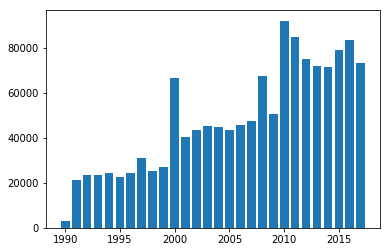

In [7]:
plt.bar(range(1990,2018),[len(data[data['ORIGYEAR']==year]) for year in range(1990,2018)])
plt.show()

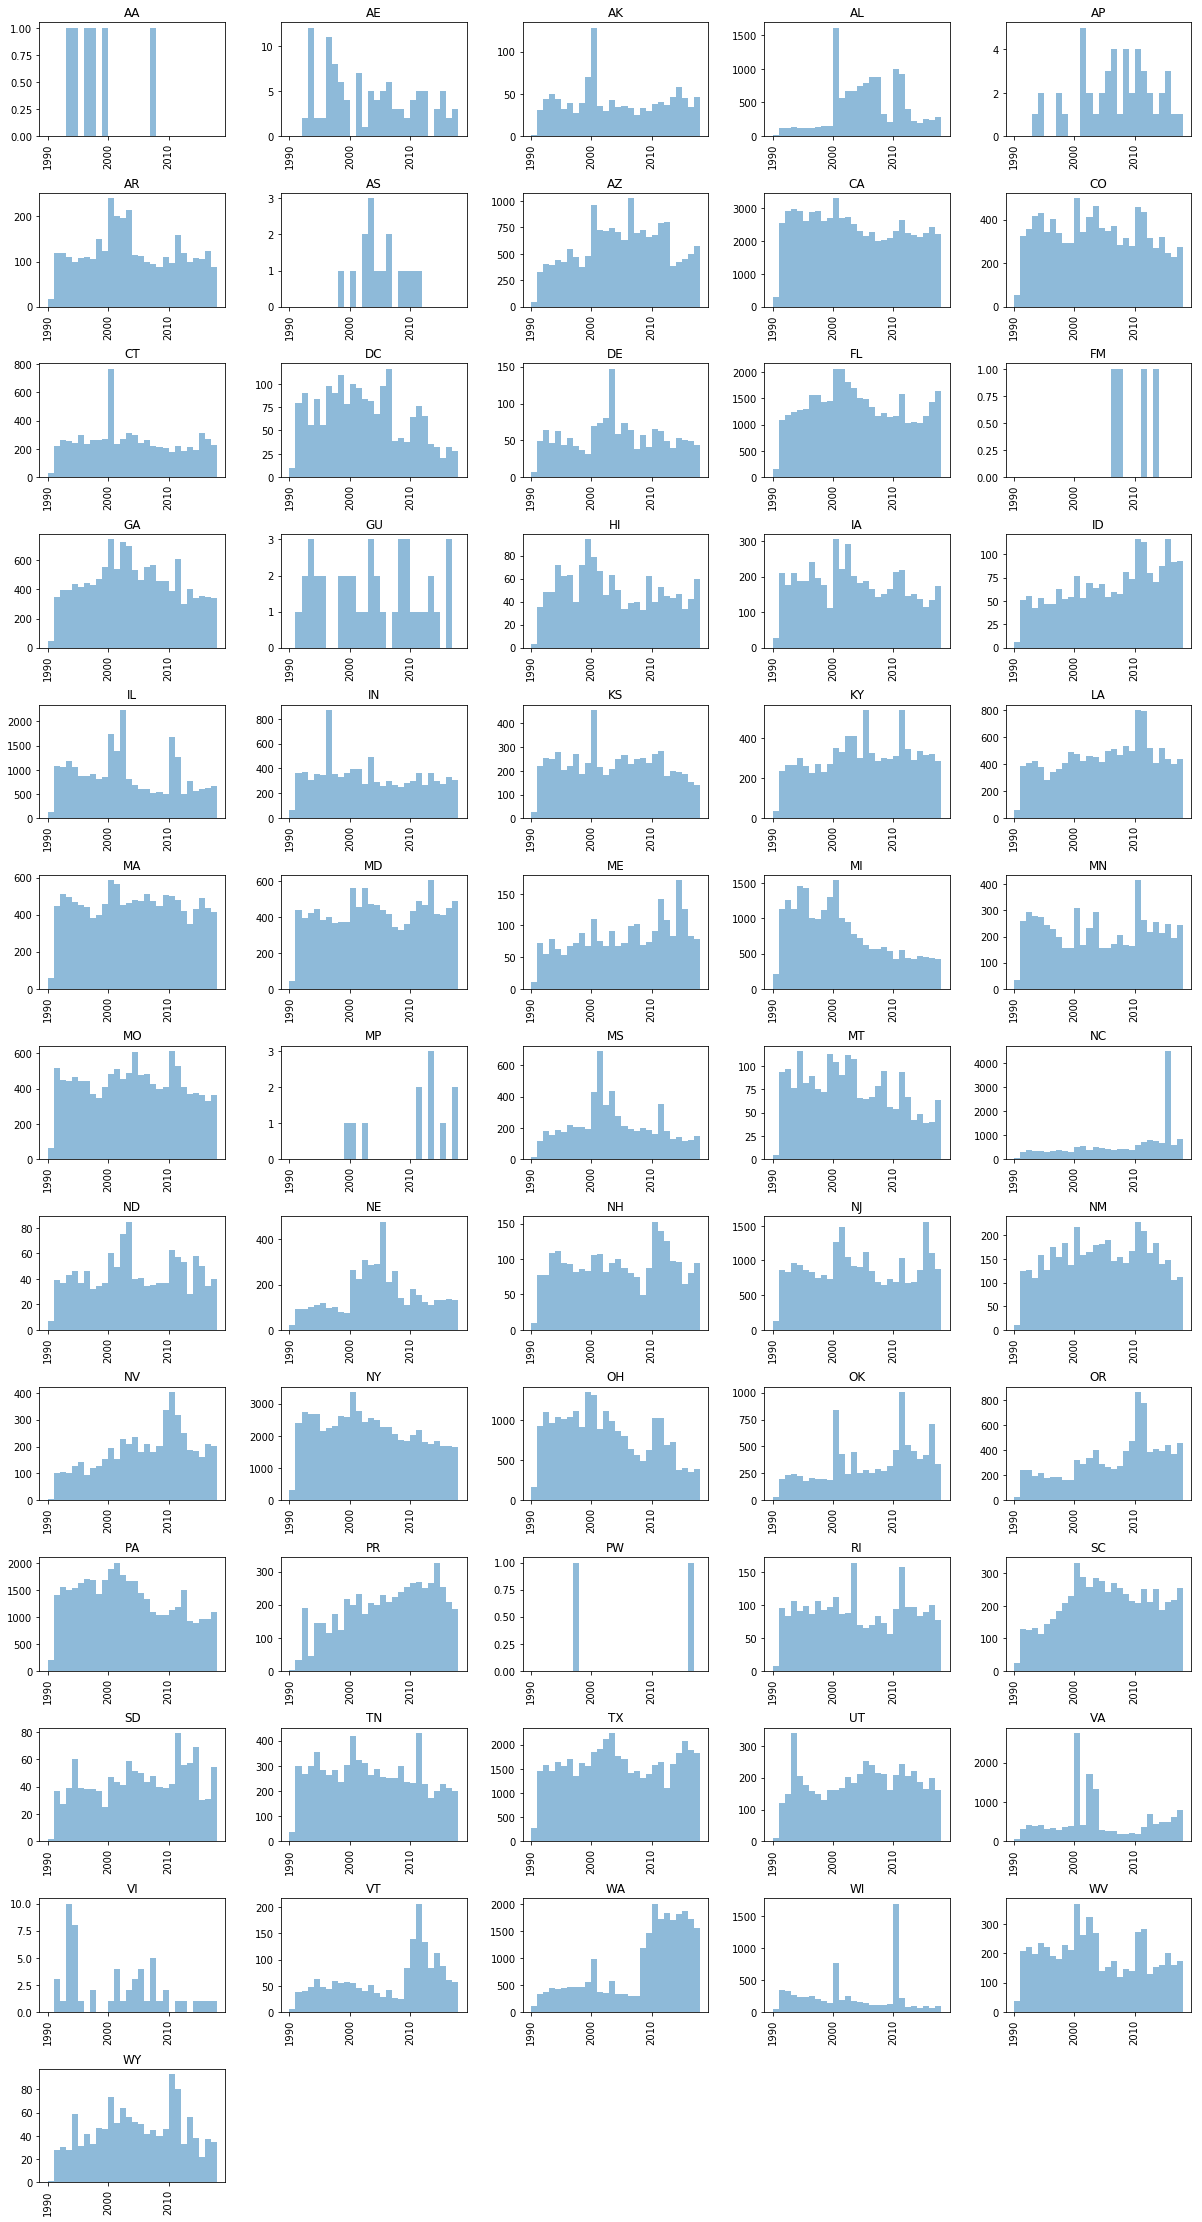

In [4]:
data.hist(column='ORIGYEAR',bins=2018-1990,range=(1990,2018),alpha=0.5,by='WORKSTAT',figsize=(20,40),layout=(13,5))
plt.show()

In [8]:
common_states = np.intersect1d(list(data["WORKSTAT"].unique()),list(state_pop["State Abb"]))

In [9]:
data["PAYMENT"].replace('[\$,]', '', regex=True, inplace=True)

In [321]:
pay_count = None
for state in common_states:
    #print(state)
    arrays = [[state,state], ['pay_per_case', 'count_per_1000000']]
    column_names = pd.MultiIndex.from_arrays(arrays).T
    mean_payment = [pd.to_numeric(data[(data["WORKSTAT"]==state) & (data["ORIGYEAR"]==i)]['PAYMENT']).mean() for i in range(1990,2018)]
    count_per_capita = [1000000*len(data[(data["WORKSTAT"]==state) & (data["ORIGYEAR"]==i)])/state_pop[state_pop["State Abb"]==state][2016][0] for i in range(1990,2018)]
    stack = pd.DataFrame(np.stack((mean_payment,
                                   count_per_capita),axis=0).T,
                         columns=column_names,
                         index=range(1990,2018))
    #print(stack)
    if type(pay_count)==None:
        pay_count = stack
    else:
        pay_count = pd.concat([pay_count, stack], axis=1)

In [322]:
state_slope = []
for state in common_states:
    slope, intercept, rvalue, pvalue, stderr = scipy.stats.linregress(range(1991,2018),
                                                                      pay_count[state,"count_per_1000000"][1:])
    state_slope.append([state,slope,intercept])
    
df_state_slope=pd.DataFrame(state_slope,columns=["state","slope","intercept"])
#df_state_slope #.sort_values("slope")

In [323]:
correlation_slope = np.zeros((len(common_states),len(common_states)))

for state1 in range(len(common_states)):
    for state2 in range(len(common_states)):
        #print(float(df_state_slope[df_state_slope["state"]==common_states[state1]]["slope"]))
        #print(float(df_state_slope[df_state_slope["state"]==common_states[state2]]["slope"]))
        correlation_slope[state1,state2] = ((
            float(df_state_slope[df_state_slope["state"]==common_states[state1]]["slope"])-
            float(df_state_slope[df_state_slope["state"]==common_states[state2]]["slope"])))**2
        
#print(correlation_slope)

In [336]:
from sklearn.cluster import DBSCAN
# Compute DBSCAN

db = DBSCAN(eps=0.05, min_samples=1,metric='precomputed').fit_predict(correlation_slope)
#core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
#core_samples_mask[db.core_sample_indices_] = True
#for i in np.unique(db):
#    print(i,common_states[np.where(db==i)])
    
df_state_cluster = pd.DataFrame(db.T,columns=["cluster"])
df_state_slope_cluster = pd.concat([df_state_slope,df_state_cluster],axis=1)

average_slopes = []
for state in common_states:
    current_cluster = int(df_state_slope_cluster[df_state_slope_cluster["state"]==state]["cluster"])
    #print(current_cluster)
    average_slope = df_state_slope_cluster[df_state_slope_cluster["cluster"]==current_cluster]["slope"].mean()
    average_slopes.append(average_slope)
    
df_cluster_slope = pd.DataFrame(np.array(average_slopes).T,columns=["avg_slopes"])
df_state_slope_cluster_aslope = pd.concat([df_state_slope_cluster,df_cluster_slope],axis=1)

cluster_colors = pd.DataFrame(np.array(average_slopes).T,columns=["cl_colors"])
df_state_slope_cluster_aslope_acolor = pd.concat([df_state_slope_cluster_aslope,cluster_colors],axis=1)

start = 0
for i in np.unique(df_state_slope_cluster_aslope["avg_slopes"].sort_values()):
    #print(i)
    #print(start)
    df_state_slope_cluster_aslope_acolor.replace(to_replace= {'cl_colors': {i: start}}, inplace=True)
    start += 1

df_state_slope_cluster_aslope_acolor

,state,slope,intercept,cluster,avg_slopes,cl_colors
0,AK,-0.203255,464.733599,0,-0.128846,4.0
1,AL,2.025211,-3966.951698,1,1.949438,6.0
2,AR,-0.317074,677.656642,0,-0.128846,4.0
3,AZ,0.962205,-1842.375372,0,-0.128846,4.0
4,CA,-0.782451,1631.942116,0,-0.128846,4.0
5,CO,-0.664984,1395.570399,0,-0.128846,4.0
6,CT,-0.742375,1561.524534,0,-0.128846,4.0
7,DC,-3.223822,6561.454579,2,-3.223822,1.0
8,DE,-0.160951,382.493131,0,-0.128846,4.0
9,FL,-0.289428,647.640492,0,-0.128846,4.0


CLUSTER 0


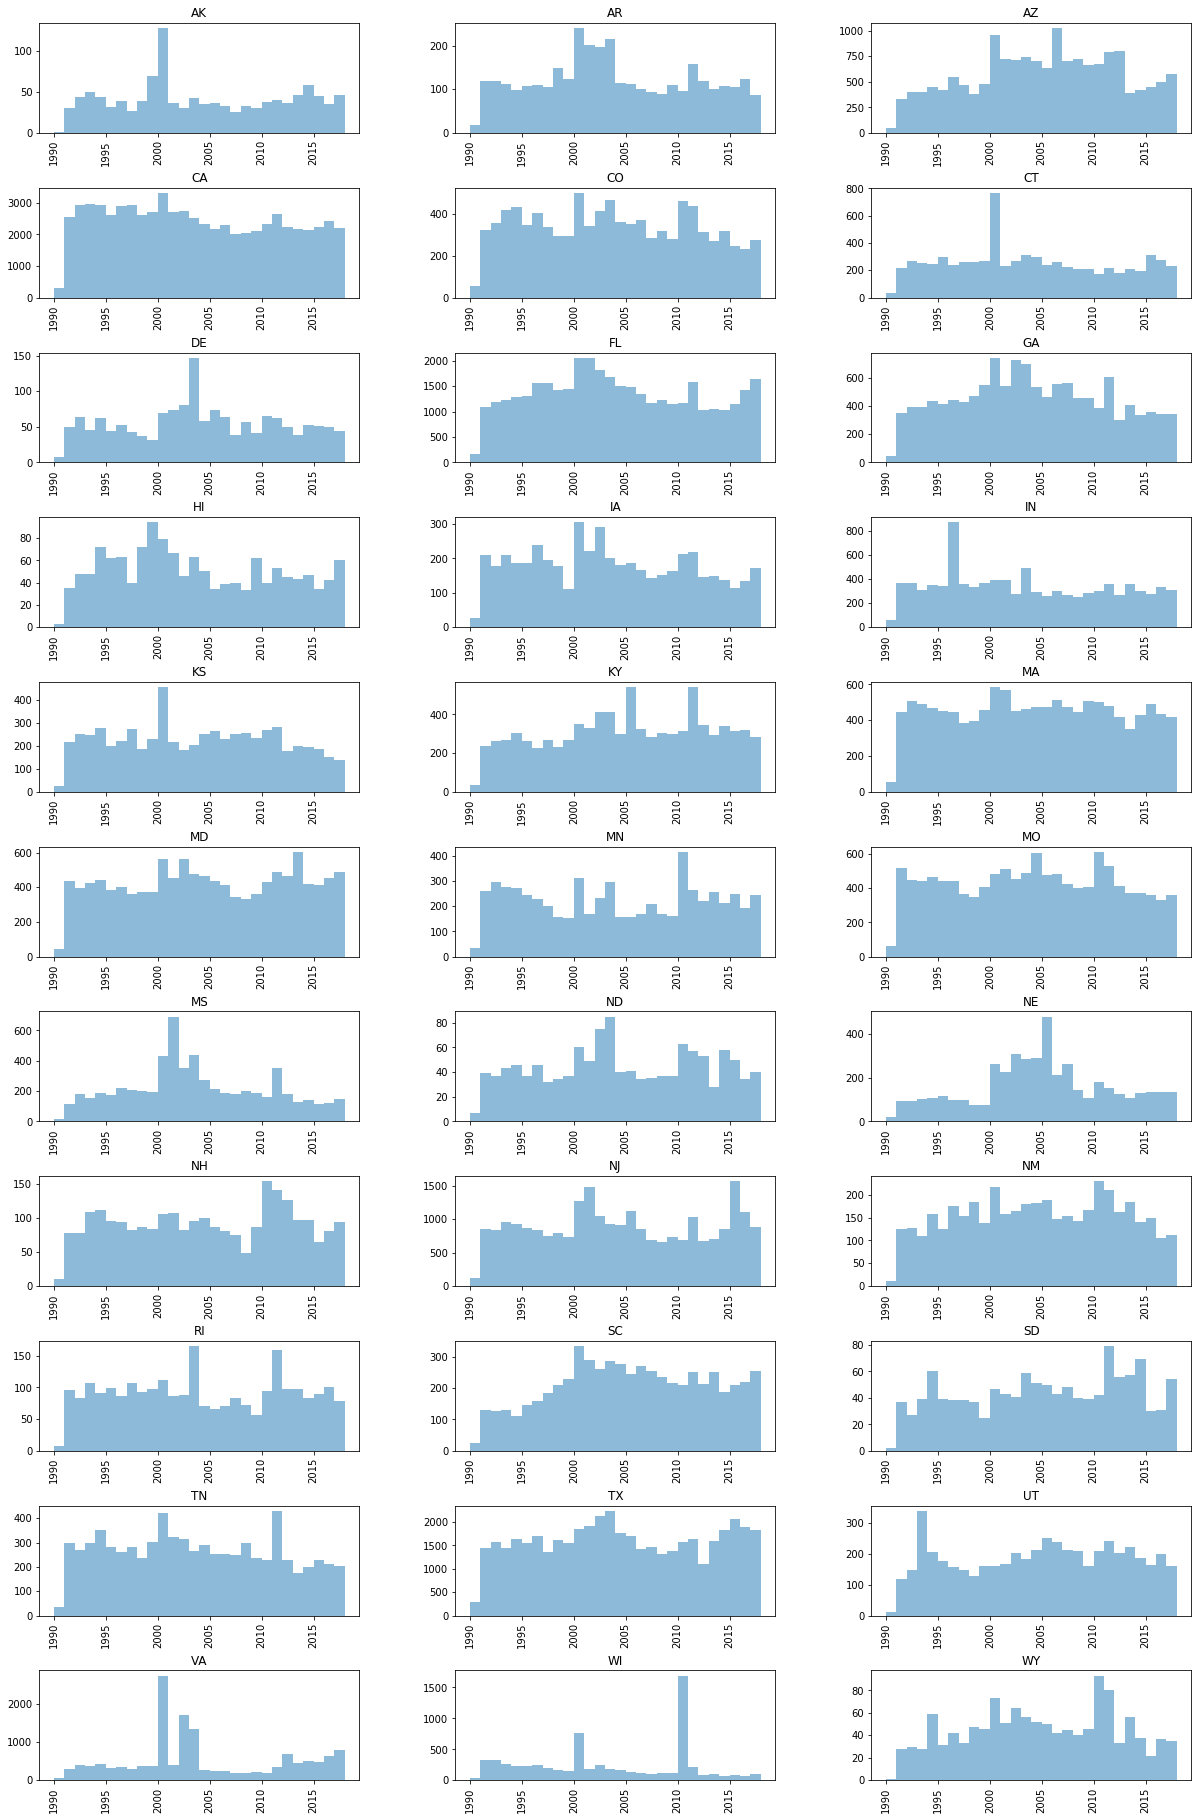

CLUSTER 1


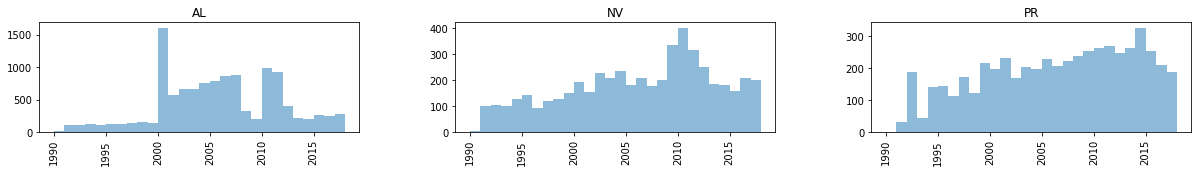

CLUSTER 2


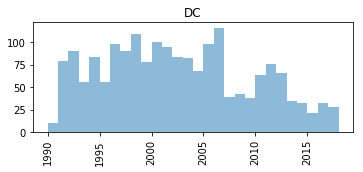

CLUSTER 3


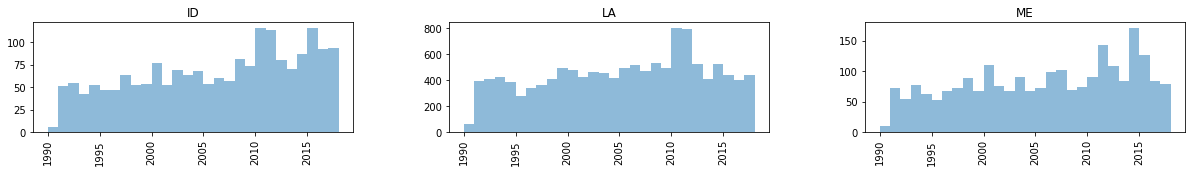

CLUSTER 4


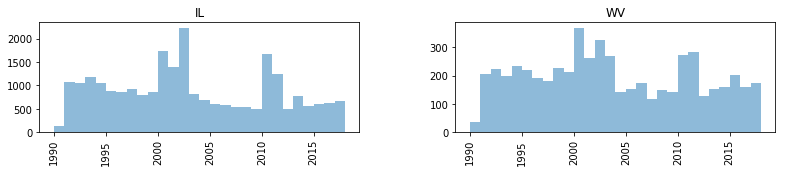

CLUSTER 5


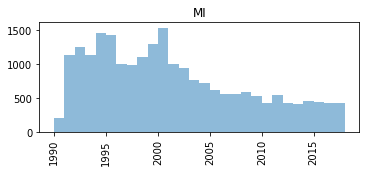

CLUSTER 6


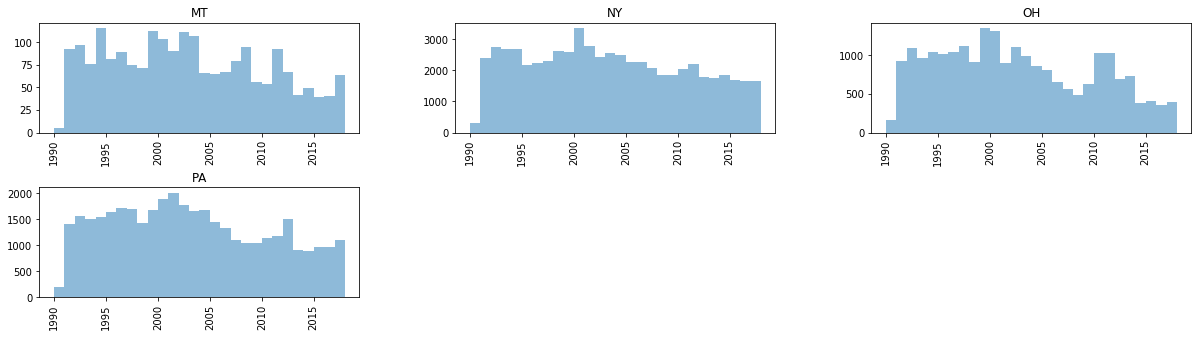

CLUSTER 7


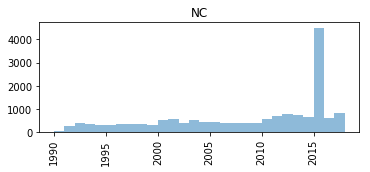

CLUSTER 8


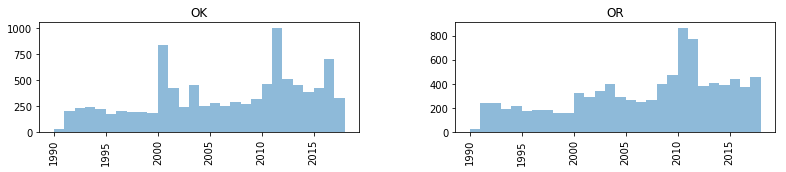

CLUSTER 9


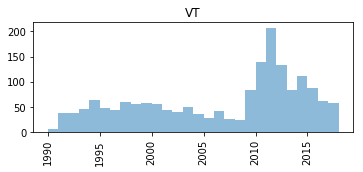

CLUSTER 10


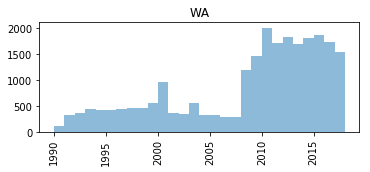

In [338]:
for i in range(len(np.unique(db))):
    print("CLUSTER "+str(i))
    data[data["WORKSTAT"].isin(list(common_states[np.where(db==i)]))].hist(column='ORIGYEAR',bins=2018-1990,range=(1990,2018),alpha=0.5,by='WORKSTAT',figsize=(20,60),layout=(20,3))
    plt.show()

In [339]:
from bokeh.io import show, save, output_notebook, export_png
from bokeh.models import (
    ColumnDataSource,
    HoverTool,
    ContinuousColorMapper,
    LabelSet,
    Label,
    LogColorMapper, 
    LogTicker, 
    FixedTicker,
    ColorBar, 
    LinearColorMapper,
    Legend
)
from bokeh.plotting import figure, output_file, show
from bokeh.sampledata.us_states import data as states
from bokeh.resources import CDN
from bokeh.embed import file_html
from bokeh.palettes import PRGn11 as palette
from bokeh.palettes import Category20,Spectral11,Category10,PRGn11

In [340]:
try:
    del states["HI"]
    del states["AK"]
except:
    pass

palette.reverse()

states = {
    code: state for code, state in states.items()
}
#print(states)

state_xs = [states[code]["lons"] for code in states]
state_ys = [states[code]["lats"] for code in states]
state_names = [state['name'] for state in states.values()]

state_rates = []
for name in state_names:
    abbr = state_pop.loc[name]["State Abb"]
    state_rates.append(float(df_state_slope[df_state_slope["state"]==abbr]["slope"]))
#print(state_rates)

lat_inkm = 111.132 ## at around lat = 45degrees from the wiki latitude page
lon_inkm = 78.847 ## at around lat = 45degrees from the wiki latitude page

In [341]:
text_position_x = []
for statex in state_xs:
    text_position_x.append(float("%.5f" % round(max(statex)-(max(statex)-min(statex))/2,5)))
    
text_position_y = []
for statey in state_ys:
    text_position_y.append(float("%.5f" % round(max(statey)-(max(statey)-min(statey))/2,5)))

In [342]:
state_clusters=[]
for name in state_names:
    abbr = state_pop.loc[name]["State Abb"]
    state_clusters.append(palette[int(df_state_slope_cluster_aslope_acolor[df_state_slope_cluster_aslope_acolor["state"]==abbr]["cl_colors"])])

#state_clusters

In [361]:
cluster_label = []
for name in state_names:
    abbr = state_pop.loc[name]["State Abb"]
    cluster_label.append(int(df_state_slope_cluster_aslope_acolor[df_state_slope_cluster_aslope_acolor["state"]==abbr]["cluster"]))

#cluster_label

[1,
 0,
 0,
 0,
 0,
 0,
 0,
 3,
 0,
 6,
 0,
 0,
 1,
 0,
 0,
 0,
 6,
 0,
 9,
 0,
 5,
 0,
 7,
 0,
 3,
 0,
 2,
 0,
 0,
 0,
 8,
 0,
 0,
 0,
 3,
 0,
 0,
 6,
 0,
 0,
 4,
 10,
 0,
 8,
 4,
 0,
 0,
 6,
 0]

In [364]:
output_notebook()

color_mapper = LinearColorMapper(palette=palette, low=min(state_rates), high=max(state_rates))
#ticker = FixedTicker(ticks=np.unique(df_state_slope_cluster_aslope_acolor["avg_slopes"]))

source = ColumnDataSource(data=dict(
    x=state_xs,
    y=state_ys,
    name=state_names,
    rate=state_rates,
    clusters=state_clusters,
    cluster_label=cluster_label,
))

TOOLS = "pan,wheel_zoom,reset,hover,save"

p = figure(title="Change in the number of malpractice cases filed per a million citizens per states, 1990-2018", 
    plot_width=int((max(max(state_xs))-min(min(state_xs)))*lon_inkm/4.5), 
    plot_height=int((max(max(state_ys))-min(min(state_ys)))*lat_inkm/4.5), tools=TOOLS,
    x_axis_location=None, y_axis_location=None
)

p.grid.grid_line_color = None

p.patches('x', 'y', source=source,
          fill_color='clusters',
          fill_alpha=0.7, line_color="gray", line_width=0.5)

color_bar = ColorBar(color_mapper=color_mapper, #ticker=ticker,
                     label_standoff=12, border_line_color=None, location=(0,0))

p.add_layout(color_bar, 'right')

hover = p.select_one(HoverTool)
hover.point_policy = "follow_mouse"
hover.tooltips ="""
    <font size="3">State: <strong>@name</strong> </font> <br>
    <font size="3">Change in the number of malpractice cases </font> <br>
    <font size="3">per year from 1990 to 2018: <strong>@rate per 1,000,000</strong> </font> <br>
    <font size="3">Cluster: <strong>@cluster_label</strong> </font>
"""

#save(p, filename="malpractice.html", title="Medical Malpractice", resource='cdn')

#export_png(p, filename='malpractice.png')

#output_file("Map_of_malpractice_cases.html",title="Map of malpractice cases")
#p.save_figure("malpractice.png",dpi=300)
show(p)





Loading BokehJS ...

In [377]:
p = figure(plot_width=850, plot_height=500, tools=[hover], x_axis_label='Years', y_axis_label='Malpractice cases filed per 1,000,000')
p.title.text = "Malpractice case per 1,000,000 citizens per year for a group of states which successfully diminished this number in the last two decades."

cluster_num = 6
cur_states = list(df_state_slope_cluster_aslope_acolor[df_state_slope_cluster_aslope_acolor["cluster"]==cluster_num]["state"])

for state, color in zip(cur_states, Category20[20]):
    curve = pay_count[state,"count_per_10000"]
    plt.plot(range(1990,2018),curve,label=state,marker='.')
    p.line(curve.index, curve,line_width=2, color=color, alpha=1.,
           muted_color=color, muted_alpha=0.2, legend=state)

p.legend.location = "top_left"
p.legend.click_policy="mute"

output_notebook()

#output_file("interactive_legend.html", title="interactive_legend.py example")

show(p)

Loading BokehJS ...

In [378]:
from bokeh.io import output_file, show
from bokeh.layouts import widgetbox
from bokeh.models.widgets import Dropdown

output_file("dropdown.html")

curve = pay_count[state,"count_per_10000"]
    plt.plot(range(1990,2018),curve,label=state,marker='.')
    p.line(curve.index, curve,line_width=2, color=color, alpha=1.,
           muted_color=color, muted_alpha=0.2, legend=state)
    
    
callback = CustomJS(args=dict(source=source), code="""
        var data = source.data;
        var f = cb_obj.value
        x = data['x']
        y = data['y']
        for (i = 0; i < x.length; i++) {
            y[i] = Math.pow(x[i], f)
        }
        source.change.emit();
    """)

menu = [("State Cluster 0", "0"), 
        ("State Cluster 1", "1"), 
        ("State Cluster 2", "2"), 
        ("State Cluster 3", "3"), 
        ("State Cluster 4", "4"), 
        ("State Cluster 5", "5"), 
        ("State Cluster 6", "6"), 
        ("State Cluster 7", "7"), 
        ("State Cluster 8", "8"), 
        ("State Cluster 9", "9"), 
        ("State Cluster 10", "10"), 
        ("State Cluster 11", "11"), 
        ]
dropdown = Dropdown(label="Select State and Field", button_type="warning", menu=menu, callback=callback)

output_notebook()

#show(widgetbox(dropdown))
layout = column(dropdown, plot)

show(layout)

Loading BokehJS ...

In [359]:
from bokeh.layouts import column
from bokeh.models import CustomJS, ColumnDataSource, Slider, Dropdown
from bokeh.plotting import figure, output_file, show
from bokeh.layouts import widgetbox

output_file("callback.html")

## initial data

x = [x*0.005 for x in range(0, 200)]
y = x


## set initial source
source = ColumnDataSource(data=dict(x=x, y=y))

## set initial plot
plot = figure(plot_width=800, plot_height=500)
plot.line('x', 'y', source=source, line_width=3, line_alpha=0.6)

## callback
callback = CustomJS(args=dict(source=source), code="""
        var data = source.data;
        var f = cb_obj.value
        x = data['x']
        y = data['y']
        for (i = 0; i < x.length; i++) {
            y[i] = Math.pow(x[i], f)
        }
        source.change.emit();
    """)

##widget
slider = Slider(start=0.1, end=4, value=1, step=.1, title="power", callback=callback)
menu = [("Item 1", "item_1"), ("Item 2", "item_2"), ("Item 3", "item_3")]
dropdown = Dropdown(label="Select State and Field", button_type="warning", menu=menu)

layout = column(dropdown, plot)

show(layout)

In [354]:
from bokeh.layouts import column
from bokeh.models import CustomJS, ColumnDataSource, Slider, Dropdown
from bokeh.plotting import figure, output_file, show
from bokeh.layouts import widgetbox

output_file("callback.html")

x = [x*0.005 for x in range(0, 200)]
y = x

source = ColumnDataSource(data=dict(x=x, y=y))

plot = figure(plot_width=400, plot_height=400)
plot.line('x', 'y', source=source, line_width=3, line_alpha=0.6)

callback = CustomJS(args=dict(source=source), code="""
        var data = source.data;
        var f = cb_obj.value
        x = data['x']
        y = data['y']
        for (i = 0; i < x.length; i++) {
            y[i] = Math.pow(x[i], f)
        }
        source.change.emit();
    """)

slider = Slider(start=0.1, end=4, value=1, step=.1, title="power", callback=callback)

layout = column(slider, plot)

show(layout)